Analyses how kappa controls the covariance versus variance constraint

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *
from decorrelation.utils import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def train(num_epochs, data, model):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
    
    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

In [3]:
num_samples=1000
num_features=100
num_epochs=300
seed=40
decor_lr=1e-2
bias_lr=0.0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = 0.5 * generate_correlated_data(num_features, num_samples, strength=0.5).to(device)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

kappas = np.linspace(0,0.02,20)
D = np.zeros(len(kappas))
C = np.zeros(len(kappas))
for i, kappa in enumerate(kappas):

    model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa).to(device)

    L, A1, A2 = train(num_epochs, data, model)
    
    C[i] = torch.mean(lower_triangular(torch.abs(A2), offset=-1))
    D[i] = torch.mean(torch.diag(A2))


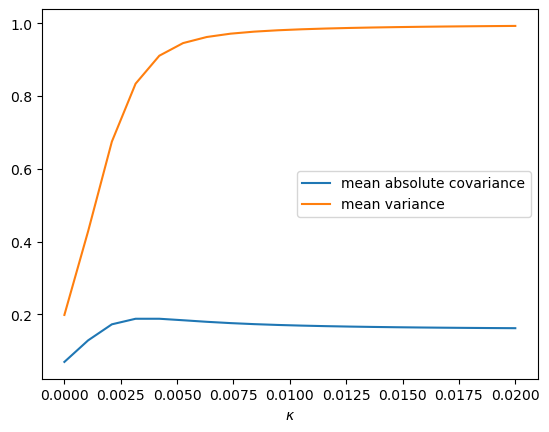

In [4]:
plt.plot(kappas, C)
plt.plot(kappas, D)
plt.xlabel('$\kappa$')
plt.legend(['mean absolute covariance', 'mean variance']);

In [5]:
C


array([0.06970666, 0.12894587, 0.17299744, 0.18828367, 0.18830556,
       0.18420421, 0.17992413, 0.17634968, 0.17350897, 0.17126004,
       0.16946213, 0.16800603, 0.16681166, 0.165821  , 0.16499132,
       0.1642909 , 0.16369568, 0.16318716, 0.16275093, 0.16237552])

In [6]:
D

array([0.19879635, 0.42875504, 0.67491454, 0.83412355, 0.9109683 ,
       0.94563746, 0.96238869, 0.97151774, 0.97711563, 0.98088092,
       0.98358762, 0.98562819, 0.98722112, 0.98849875, 0.98954558,
       0.99041855, 0.99115753, 0.99179077, 0.99233937, 0.99281931])